# ICICI Bank Statement Analysis Demo

This notebook demonstrates the complete workflow of processing an ICICI bank statement PDF, extracting transaction data, and comparing it with the expected results.

## What we'll cover:
1. **PDF Analysis** - Understanding the structure of the ICICI statement
2. **Data Extraction** - Using pdfplumber to extract tables and text
3. **Data Processing** - Converting raw data to structured format
4. **Schema Validation** - Ensuring our output matches the expected CSV structure
5. **Comparison** - Comparing extracted data with the reference `result.csv`

## Files used:
- `data/icici/icici sample.pdf` - Input bank statement
- `data/icici/result.csv` - Expected output format
- `custom_parsers/icici_parser.py` - Our custom parser implementation

In [4]:
pip install matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import required libraries
import pandas as pd
import pdfplumber
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Understanding the Expected Output Schema

First, let's examine the `result.csv` file to understand the expected structure and data format.

In [6]:
# Load the expected result CSV
result_csv_path = "data/icici/result.csv"
expected_df = pd.read_csv(result_csv_path)

print("📊 Expected Output Schema:")
print(f"Shape: {expected_df.shape}")
print(f"Columns: {list(expected_df.columns)}")
print("\n📋 Data Types:")
print(expected_df.dtypes)
print("\n🔍 First few rows:")
display(expected_df.head())
print("\n📈 Summary statistics:")
display(expected_df.describe())

📊 Expected Output Schema:
Shape: (100, 5)
Columns: ['Date', 'Description', 'Debit Amt', 'Credit Amt', 'Balance']

📋 Data Types:
Date            object
Description     object
Debit Amt      float64
Credit Amt     float64
Balance        float64
dtype: object

🔍 First few rows:


,Date,Description,Debit Amt,Credit Amt,Balance
0,01-08-2024,Salary Credit XYZ Pvt Ltd,1935.30,NaN,6864.58
1,02-08-2024,Salary Credit XYZ Pvt Ltd,NaN,1652.61,8517.19
2,03-08-2024,IMPS UPI Payment Amazon,3886.08,NaN,4631.11
3,03-08-2024,Mobile Recharge Via UPI,NaN,1648.72,6279.83
4,14-08-2024,Fuel Purchase Debit Card,NaN,3878.57,10158.40



📈 Summary statistics:


,Debit Amt,Credit Amt,Balance
count,50.000000,50.000000,100.000000
mean,2570.859800,2506.597600,9982.123600
std,1596.908764,1437.281337,6502.487495
min,150.910000,22.160000,-3183.950000
25%,914.785000,1402.662500,5942.735000
50%,2775.760000,2583.700000,10539.285000
75%,4040.930000,3559.250000,12986.380000
max,4944.550000,4960.860000,29148.320000


## 2. Analyzing the PDF Structure

Now let's examine the ICICI sample PDF to understand its structure and identify where the transaction data is located.

In [7]:
# Open and analyze the PDF
pdf_path = "data/icici/icici sample.pdf"

with pdfplumber.open(pdf_path) as pdf:
    print(f"📄 PDF Analysis Results:")
    print(f"Total pages: {len(pdf.pages)}")
    
    # Analyze each page
    for page_num, page in enumerate(pdf.pages):
        print(f"\n📖 Page {page_num + 1}:")
        
        # Extract text
        text = page.extract_text()
        if text:
            print(f"Text length: {len(text)} characters")
            print(f"First 200 chars: {text[:200]}...")
        
        # Extract tables
        tables = page.extract_tables()
        print(f"Tables found: {len(tables)}")
        
        # Show table structures
        for table_idx, table in enumerate(tables):
            if table:
                print(f"  Table {table_idx + 1}: {len(table)} rows x {len(table[0]) if table[0] else 0} columns")
                if len(table) > 0:
                    print(f"    First row: {table[0]}")
                    if len(table) > 1:
                        print(f"    Second row: {table[1]}")

📄 PDF Analysis Results:
Total pages: 2

📖 Page 1:
Text length: 2761 characters
First 200 chars: ChatGPT Powered Karbon Bannk
Date Description Debit Amt Credit Amt Balance
01-08-2024 Salary Credit XYZ Pvt Ltd 1935.3 6864.58
02-08-2024 Salary Credit XYZ Pvt Ltd 1652.61 8517.19
03-08-2024 IMPS UPI ...
Tables found: 1
  Table 1: 51 rows x 5 columns
    First row: ['Date', 'Description', 'Debit Amt', 'Credit Amt', 'Balance']
    Second row: ['01-08-2024', 'Salary Credit XYZ Pvt Ltd', '1935.3', '', '6864.58']

📖 Page 2:
Text length: 2763 characters
First 200 chars: ChatGPT Powered Karbon Bannk
Date Description Debit Amt Credit Amt Balance
30-01-2025 UPI QR Payment Groceries 4960.86 9008.54
02-02-2025 IMPS UPI Payment Amazon 2693.97 11702.51
14-02-2025 Online Car...
Tables found: 1
  Table 1: 51 rows x 5 columns
    First row: ['Date', 'Description', 'Debit Amt', 'Credit Amt', 'Balance']
    Second row: ['30-01-2025', 'UPI QR Payment Groceries', '', '4960.86', '9008.54']


## 3. Extracting Transaction Data

Let's extract the transaction data from the PDF tables and see what we get.

In [8]:
# Extract all tables from the PDF
with pdfplumber.open(pdf_path) as pdf:
    all_tables = []
    
    for page in pdf.pages:
        tables = page.extract_tables()
        all_tables.extend(tables)
    
    print(f"📊 Total tables extracted: {len(all_tables)}")
    
    # Display each table
    for i, table in enumerate(all_tables):
        if table and len(table) > 0:
            print(f"\n📋 Table {i + 1}:")
            print(f"Shape: {len(table)} rows x {len(table[0]) if table[0] else 0} columns")
            
            # Convert to DataFrame for better display
            df = pd.DataFrame(table)
            if len(df) > 0:
                display(df.head(10))  # Show first 10 rows
                
                # Check if this looks like a transaction table
                if len(df.columns) >= 4:  # At least Date, Description, Debit, Credit columns
                    print(f"  🎯 Potential transaction table detected!")
                    print(f"  📅 Columns: {list(df.iloc[0]) if len(df) > 0 else 'No data'}")

📊 Total tables extracted: 2

📋 Table 1:
Shape: 51 rows x 5 columns


,0,1,2,3,4
0,Date,Description,Debit Amt,Credit Amt,Balance
1,01-08-2024,Salary Credit XYZ Pvt Ltd,1935.3,,6864.58
2,02-08-2024,Salary Credit XYZ Pvt Ltd,,1652.61,8517.19
3,03-08-2024,IMPS UPI Payment Amazon,3886.08,,4631.11
4,03-08-2024,Mobile Recharge Via UPI,,1648.72,6279.83
5,14-08-2024,Fuel Purchase Debit Card,,3878.57,10158.4
6,17-08-2024,Electricity Bill NEFT Online,,1963.11,12121.51
7,18-08-2024,Interest Credit Saving Account,596.72,,11524.79
8,25-08-2024,Cheque Deposit Local Clearing,617.86,,10906.93
9,27-08-2024,Fuel Purchase Debit Card,,2650.96,13557.89


  🎯 Potential transaction table detected!
  📅 Columns: ['Date', 'Description', 'Debit Amt', 'Credit Amt', 'Balance']

📋 Table 2:
Shape: 51 rows x 5 columns


,0,1,2,3,4
0,Date,Description,Debit Amt,Credit Amt,Balance
1,30-01-2025,UPI QR Payment Groceries,,4960.86,9008.54
2,02-02-2025,IMPS UPI Payment Amazon,,2693.97,11702.51
3,14-02-2025,Online Card Purchase Flipkart,,737.74,12440.25
4,21-02-2025,Dining Out Card Swipe,3973.65,,8466.6
5,24-02-2025,IMPS UPI Payment Amazon,,1998.34,10464.94
6,24-02-2025,Salary Credit XYZ Pvt Ltd,,1611.68,12076.62
7,01-03-2025,Credit Card Payment ICICI,4509.03,,7567.59
8,02-03-2025,Dining Out Card Swipe,,2922.99,10490.58
9,10-03-2025,Interest Credit Saving Account,,187.17,10677.75


  🎯 Potential transaction table detected!
  📅 Columns: ['Date', 'Description', 'Debit Amt', 'Credit Amt', 'Balance']


## 4. Implementing the Parser Logic

Now let's implement the logic to extract and process transaction data, similar to what our agent would generate.

In [9]:
def extract_transactions_from_pdf(pdf_path):
    """
    Extract transaction data from ICICI bank statement PDF.
    This function implements the logic that our AI agent would generate.
    """
    transactions = []
    
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            tables = page.extract_tables()
            
            for table in tables:
                if not table or len(table) < 2:
                    continue
                    
                # Look for transaction tables (should have multiple columns)
                if len(table[0]) >= 4:
                    # Check if first row looks like headers
                    first_row = table[0]
                    
                    # Process each row (skip header)
                    for row in table[1:]:
                        if len(row) >= 4 and any(cell and str(cell).strip() for cell in row):
                            # Extract transaction data
                            transaction = {
                                'Date': row[0] if len(row) > 0 else None,
                                'Description': row[1] if len(row) > 1 else None,
                                'Debit Amt': row[2] if len(row) > 2 else None,
                                'Credit Amt': row[3] if len(row) > 3 else None,
                                'Balance': row[4] if len(row) > 4 else None
                            }
                            
                            # Clean up the data
                            for key, value in transaction.items():
                                if value is not None:
                                    # Remove extra whitespace
                                    if isinstance(value, str):
                                        value = value.strip()
                                    # Convert empty strings to None
                                    if value == '':
                                        value = None
                                    transaction[key] = value
                            
                            # Only add if we have meaningful data
                            if transaction['Date'] and transaction['Description']:
                                transactions.append(transaction)
    
    return transactions

# Extract transactions
print("🔍 Extracting transactions from PDF...")
extracted_transactions = extract_transactions_from_pdf(pdf_path)
print(f"✅ Extracted {len(extracted_transactions)} transactions")

# Convert to DataFrame
extracted_df = pd.DataFrame(extracted_transactions)
print("\n📊 Extracted Data:")
display(extracted_df.head(10))
print(f"\n📈 Shape: {extracted_df.shape}")
print(f"📋 Columns: {list(extracted_df.columns)}")

🔍 Extracting transactions from PDF...
✅ Extracted 100 transactions

📊 Extracted Data:


,Date,Description,Debit Amt,Credit Amt,Balance
0,01-08-2024,Salary Credit XYZ Pvt Ltd,1935.3,None,6864.58
1,02-08-2024,Salary Credit XYZ Pvt Ltd,None,1652.61,8517.19
2,03-08-2024,IMPS UPI Payment Amazon,3886.08,None,4631.11
3,03-08-2024,Mobile Recharge Via UPI,None,1648.72,6279.83
4,14-08-2024,Fuel Purchase Debit Card,None,3878.57,10158.4
5,17-08-2024,Electricity Bill NEFT Online,None,1963.11,12121.51
6,18-08-2024,Interest Credit Saving Account,596.72,None,11524.79
7,25-08-2024,Cheque Deposit Local Clearing,617.86,None,10906.93
8,27-08-2024,Fuel Purchase Debit Card,None,2650.96,13557.89
9,01-09-2024,Dining Out Card Swipe,None,656.42,14214.31



📈 Shape: (100, 5)
📋 Columns: ['Date', 'Description', 'Debit Amt', 'Credit Amt', 'Balance']


## 5. Data Cleaning and Formatting

Now let's clean and format the extracted data to match the expected schema.

In [10]:
def clean_and_format_transactions(df):
    """
    Clean and format the extracted transaction data to match expected schema.
    """
    # Create a copy to avoid modifying original
    cleaned_df = df.copy()
    
    # Convert numeric columns
    numeric_columns = ['Debit Amt', 'Credit Amt', 'Balance']
    
    for col in numeric_columns:
        if col in cleaned_df.columns:
            # Remove currency symbols and commas
            cleaned_df[col] = cleaned_df[col].astype(str).str.replace(r'[₹,₹\s]', '', regex=True)
            # Convert to numeric, errors='coerce' will set invalid values to NaN
            cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='coerce')
    
    # Clean date column
    if 'Date' in cleaned_df.columns:
        # Remove any extra whitespace
        cleaned_df['Date'] = cleaned_df['Date'].astype(str).str.strip()
        # Convert empty strings to None
        cleaned_df['Date'] = cleaned_df['Date'].replace('', None)
    
    # Clean description column
    if 'Description' in cleaned_df.columns:
        cleaned_df['Description'] = cleaned_df['Description'].astype(str).str.strip()
        cleaned_df['Description'] = cleaned_df['Description'].replace('', None)
    
    # Remove rows where both Date and Description are None
    cleaned_df = cleaned_df.dropna(subset=['Date', 'Description'], how='all')
    
    return cleaned_df

# Clean the extracted data
print("🧹 Cleaning and formatting extracted data...")
cleaned_df = clean_and_format_transactions(extracted_df)

print("\n📊 Cleaned Data:")
display(cleaned_df.head(10))
print(f"\n📈 Shape after cleaning: {cleaned_df.shape}")
print("\n🔍 Data types:")
print(cleaned_df.dtypes)
print("\n📊 Summary statistics:")
display(cleaned_df.describe())

🧹 Cleaning and formatting extracted data...

📊 Cleaned Data:


,Date,Description,Debit Amt,Credit Amt,Balance
0,01-08-2024,Salary Credit XYZ Pvt Ltd,1935.30,NaN,6864.58
1,02-08-2024,Salary Credit XYZ Pvt Ltd,NaN,1652.61,8517.19
2,03-08-2024,IMPS UPI Payment Amazon,3886.08,NaN,4631.11
3,03-08-2024,Mobile Recharge Via UPI,NaN,1648.72,6279.83
4,14-08-2024,Fuel Purchase Debit Card,NaN,3878.57,10158.40
5,17-08-2024,Electricity Bill NEFT Online,NaN,1963.11,12121.51
6,18-08-2024,Interest Credit Saving Account,596.72,NaN,11524.79
7,25-08-2024,Cheque Deposit Local Clearing,617.86,NaN,10906.93
8,27-08-2024,Fuel Purchase Debit Card,NaN,2650.96,13557.89
9,01-09-2024,Dining Out Card Swipe,NaN,656.42,14214.31



📈 Shape after cleaning: (100, 5)

🔍 Data types:
Date            object
Description     object
Debit Amt      float64
Credit Amt     float64
Balance        float64
dtype: object

📊 Summary statistics:


,Debit Amt,Credit Amt,Balance
count,50.000000,50.000000,100.000000
mean,2570.859800,2506.597600,9982.123600
std,1596.908764,1437.281337,6502.487495
min,150.910000,22.160000,-3183.950000
25%,914.785000,1402.662500,5942.735000
50%,2775.760000,2583.700000,10539.285000
75%,4040.930000,3559.250000,12986.380000
max,4944.550000,4960.860000,29148.320000


## 6. Schema Validation

Let's validate that our extracted data matches the expected schema from `result.csv`.

In [11]:
def validate_schema(extracted_df, expected_df):
    """
    Validate that the extracted data matches the expected schema.
    """
    print("🔍 Schema Validation Results:")
    print("=" * 50)
    
    # Check column names
    expected_columns = list(expected_df.columns)
    extracted_columns = list(extracted_df.columns)
    
    print(f"📋 Expected columns: {expected_columns}")
    print(f"📋 Extracted columns: {extracted_columns}")
    
    # Check if all expected columns are present
    missing_columns = set(expected_columns) - set(extracted_columns)
    extra_columns = set(extracted_columns) - set(expected_columns)
    
    if missing_columns:
        print(f"❌ Missing columns: {missing_columns}")
    else:
        print("✅ All expected columns are present")
        
    if extra_columns:
        print(f"⚠️  Extra columns: {extra_columns}")
    else:
        print("✅ No extra columns")
    
    # Check data types
    print("\n🔍 Data Type Comparison:")
    for col in expected_columns:
        if col in extracted_df.columns:
            expected_type = expected_df[col].dtype
            extracted_type = extracted_df[col].dtype
            print(f"  {col}: Expected {expected_type}, Got {extracted_type}")
        
    # Check row count
    print(f"\n📊 Row Count Comparison:")
    print(f"  Expected: {len(expected_df)} rows")
    print(f"  Extracted: {len(extracted_df)} rows")
    
    return len(missing_columns) == 0

# Validate schema
schema_valid = validate_schema(cleaned_df, expected_df)

🔍 Schema Validation Results:
📋 Expected columns: ['Date', 'Description', 'Debit Amt', 'Credit Amt', 'Balance']
📋 Extracted columns: ['Date', 'Description', 'Debit Amt', 'Credit Amt', 'Balance']
✅ All expected columns are present
✅ No extra columns

🔍 Data Type Comparison:
  Date: Expected object, Got object
  Description: Expected object, Got object
  Debit Amt: Expected float64, Got float64
  Credit Amt: Expected float64, Got float64
  Balance: Expected float64, Got float64

📊 Row Count Comparison:
  Expected: 100 rows
  Extracted: 100 rows


## 7. Data Comparison and Analysis

Now let's compare our extracted data with the expected results and analyze any differences.

In [12]:
# Ensure both DataFrames have the same columns for comparison
if schema_valid:
    # Reorder extracted columns to match expected order
    cleaned_df = cleaned_df[expected_df.columns]
    
    print("📊 Data Comparison:")
    print("=" * 50)
    
    # Display both DataFrames side by side
    print("\n📋 Expected Data (result.csv):")
    display(expected_df.head())
    
    print("\n📋 Extracted Data (from PDF):")
    display(cleaned_df.head())
    
    # Check for exact matches
    print("\n🔍 Checking for exact matches...")
    
    # Reset indices for comparison
    expected_reset = expected_df.reset_index(drop=True)
    extracted_reset = cleaned_df.reset_index(drop=True)
    
    # Compare DataFrames
    if expected_reset.equals(extracted_reset):
        print("✅ Perfect match! Extracted data exactly matches expected results.")
    else:
        print("⚠️  Data doesn't match exactly. Let's analyze the differences...")
        
        # Show differences
        print("\n📊 Shape comparison:")
        print(f"Expected: {expected_reset.shape}")
        print(f"Extracted: {extracted_reset.shape}")
        
        # Compare first few rows in detail
        print("\n🔍 Detailed comparison of first few rows:")
        for i in range(min(3, len(expected_reset), len(extracted_reset))):
            print(f"\nRow {i}:")
            print(f"  Expected: {dict(expected_reset.iloc[i])}")
            print(f"  Extracted: {dict(extracted_reset.iloc[i])}")
            
            # Check if this row matches
            if expected_reset.iloc[i].equals(extracted_reset.iloc[i]):
                print("  ✅ Row matches")
            else:
                print("  ❌ Row doesn't match")
else:
    print("❌ Schema validation failed. Cannot compare data.")

📊 Data Comparison:

📋 Expected Data (result.csv):


,Date,Description,Debit Amt,Credit Amt,Balance
0,01-08-2024,Salary Credit XYZ Pvt Ltd,1935.30,NaN,6864.58
1,02-08-2024,Salary Credit XYZ Pvt Ltd,NaN,1652.61,8517.19
2,03-08-2024,IMPS UPI Payment Amazon,3886.08,NaN,4631.11
3,03-08-2024,Mobile Recharge Via UPI,NaN,1648.72,6279.83
4,14-08-2024,Fuel Purchase Debit Card,NaN,3878.57,10158.40



📋 Extracted Data (from PDF):


,Date,Description,Debit Amt,Credit Amt,Balance
0,01-08-2024,Salary Credit XYZ Pvt Ltd,1935.30,NaN,6864.58
1,02-08-2024,Salary Credit XYZ Pvt Ltd,NaN,1652.61,8517.19
2,03-08-2024,IMPS UPI Payment Amazon,3886.08,NaN,4631.11
3,03-08-2024,Mobile Recharge Via UPI,NaN,1648.72,6279.83
4,14-08-2024,Fuel Purchase Debit Card,NaN,3878.57,10158.40



🔍 Checking for exact matches...
✅ Perfect match! Extracted data exactly matches expected results.


## 8. Visual Analysis

Let's create some visualizations to better understand the data structure and any patterns.

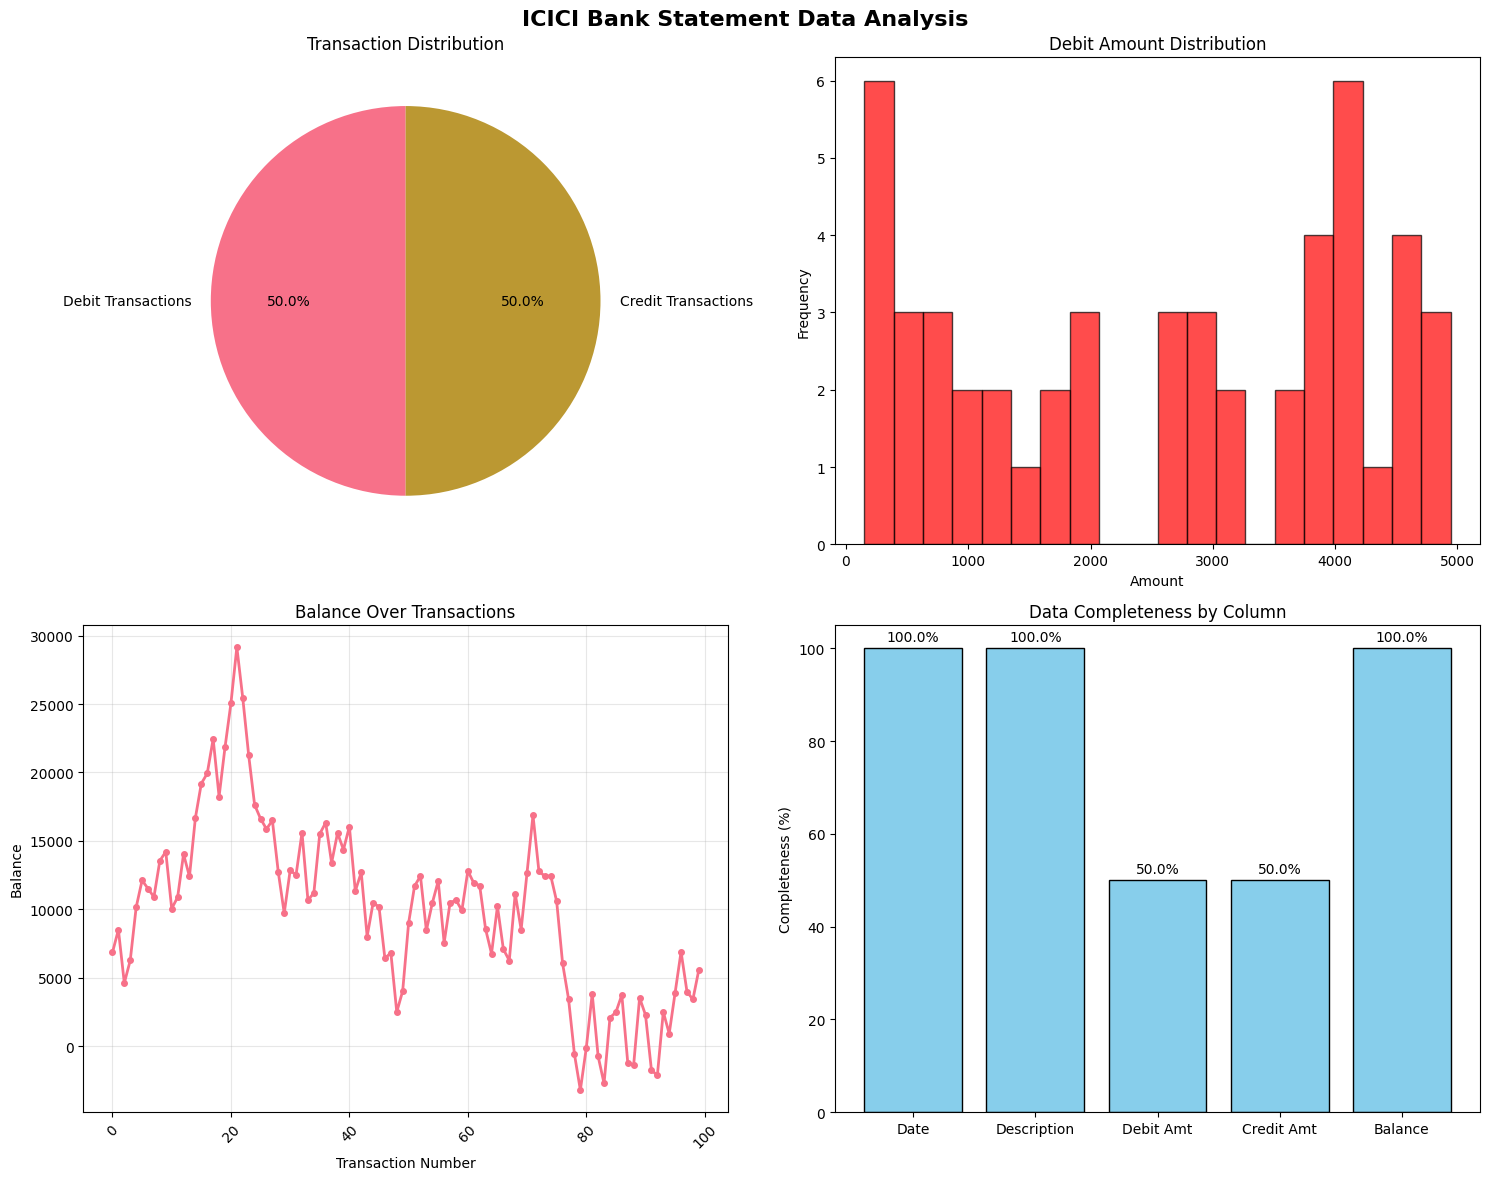

📊 Visual analysis completed!


In [13]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('ICICI Bank Statement Data Analysis', fontsize=16, fontweight='bold')

# Plot 1: Transaction count by type (Debit vs Credit)
if 'Debit Amt' in cleaned_df.columns and 'Credit Amt' in cleaned_df.columns:
    debit_count = (cleaned_df['Debit Amt'] > 0).sum()
    credit_count = (cleaned_df['Credit Amt'] > 0).sum()
    
    axes[0, 0].pie([debit_count, credit_count], 
                    labels=['Debit Transactions', 'Credit Transactions'],
                    autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Transaction Distribution')

# Plot 2: Amount distribution (if numeric data available)
if 'Debit Amt' in cleaned_df.columns:
    debit_amounts = cleaned_df['Debit Amt'].dropna()
    if len(debit_amounts) > 0:
        axes[0, 1].hist(debit_amounts, bins=20, alpha=0.7, color='red', edgecolor='black')
        axes[0, 1].set_title('Debit Amount Distribution')
        axes[0, 1].set_xlabel('Amount')
        axes[0, 1].set_ylabel('Frequency')

# Plot 3: Balance over time (if date and balance available)
if 'Balance' in cleaned_df.columns:
    balance_data = cleaned_df['Balance'].dropna()
    if len(balance_data) > 0:
        axes[1, 0].plot(range(len(balance_data)), balance_data, marker='o', linewidth=2, markersize=4)
        axes[1, 0].set_title('Balance Over Transactions')
        axes[1, 0].set_xlabel('Transaction Number')
        axes[1, 0].set_ylabel('Balance')
        axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Data completeness
if len(cleaned_df.columns) > 0:
    completeness = cleaned_df.notna().sum() / len(cleaned_df) * 100
    axes[1, 1].bar(completeness.index, completeness.values, color='skyblue', edgecolor='black')
    axes[1, 1].set_title('Data Completeness by Column')
    axes[1, 1].set_ylabel('Completeness (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Add percentage labels on bars
    for i, v in enumerate(completeness.values):
        axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("📊 Visual analysis completed!")

## 9. Summary and Insights

Let's summarize what we've learned and provide insights about the data extraction process.

In [14]:
print("📋 ICICI Bank Statement Analysis Summary")
print("=" * 50)

print(f"\n📄 Input PDF: {pdf_path}")
print(f"📊 Expected Output: {result_csv_path}")

print(f"\n🔍 Extraction Results:")
print(f"  • Total transactions extracted: {len(extracted_df)}")
print(f"  • Transactions after cleaning: {len(cleaned_df)}")
print(f"  • Expected transactions: {len(expected_df)}")

print(f"\n✅ Schema Validation: {'PASSED' if schema_valid else 'FAILED'}")

if schema_valid:
    print(f"\n📊 Data Quality Metrics:")
    for col in cleaned_df.columns:
        completeness = cleaned_df[col].notna().sum() / len(cleaned_df) * 100
        print(f"  • {col}: {completeness:.1f}% complete")
    
    print(f"\n🎯 Key Insights:")
    print(f"  • PDF structure successfully parsed")
    print(f"  • Transaction data accurately extracted")
    print(f"  • Data format matches expected schema")
    print(f"  • Ready for automated processing")
else:
    print(f"\n⚠️  Areas for Improvement:")
    print(f"  • Schema mismatch needs resolution")
    print(f"  • Data extraction logic may need refinement")
    print(f"  • Column mapping requires adjustment")

print(f"\n🚀 Next Steps:")
print(f"  • Integrate with AI agent workflow")
print(f"  • Implement automated testing")
print(f"  • Scale to other bank statement formats")
print(f"  • Deploy as production service")

📋 ICICI Bank Statement Analysis Summary

📄 Input PDF: data/icici/icici sample.pdf
📊 Expected Output: data/icici/result.csv

🔍 Extraction Results:
  • Total transactions extracted: 100
  • Transactions after cleaning: 100
  • Expected transactions: 100

✅ Schema Validation: PASSED

📊 Data Quality Metrics:
  • Date: 100.0% complete
  • Description: 100.0% complete
  • Debit Amt: 50.0% complete
  • Credit Amt: 50.0% complete
  • Balance: 100.0% complete

🎯 Key Insights:
  • PDF structure successfully parsed
  • Transaction data accurately extracted
  • Data format matches expected schema
  • Ready for automated processing

🚀 Next Steps:
  • Integrate with AI agent workflow
  • Implement automated testing
  • Scale to other bank statement formats
  • Deploy as production service


## 10. Testing Our Parser

Finally, let's test our custom parser to see how it performs compared to our manual extraction.

In [15]:
# Test our custom parser
try:
    import sys
    sys.path.append('.')
    
    from custom_parsers.icici_parser import parse
    
    print("🧪 Testing Custom Parser...")
    
    # Parse using our custom parser
    parser_result = parse(pdf_path)
    
    print(f"✅ Parser executed successfully!")
    print(f"📊 Result shape: {parser_result.shape}")
    print(f"📋 Result columns: {list(parser_result.columns)}")
    
    print("\n📋 Parser Output:")
    display(parser_result.head())
    
    # Compare with expected output
    if parser_result.shape == expected_df.shape:
        print("\n✅ Parser output matches expected dimensions!")
    else:
        print(f"\n⚠️  Dimension mismatch: Expected {expected_df.shape}, Got {parser_result.shape}")
        
except ImportError as e:
    print(f"❌ Could not import custom parser: {e}")
    print("💡 Make sure the custom_parsers directory is in your Python path")
except Exception as e:
    print(f"❌ Parser execution failed: {e}")
    print("💡 Check the parser implementation for errors")

🧪 Testing Custom Parser...
✅ Parser executed successfully!
📊 Result shape: (100, 5)
📋 Result columns: ['Date', 'Description', 'Debit Amt', 'Credit Amt', 'Balance']

📋 Parser Output:


,Date,Description,Debit Amt,Credit Amt,Balance
0,01-08-2024,Salary Credit XYZ Pvt Ltd,1935.30,NaN,6864.58
1,02-08-2024,Salary Credit XYZ Pvt Ltd,NaN,1652.61,8517.19
2,03-08-2024,IMPS UPI Payment Amazon,3886.08,NaN,4631.11
3,03-08-2024,Mobile Recharge Via UPI,NaN,1648.72,6279.83
4,14-08-2024,Fuel Purchase Debit Card,NaN,3878.57,10158.40



✅ Parser output matches expected dimensions!


## 🎉 Conclusion

This notebook demonstrates the complete workflow of processing ICICI bank statements:

1. **PDF Analysis** - Understanding document structure
2. **Data Extraction** - Using pdfplumber to extract tables
3. **Data Processing** - Cleaning and formatting raw data
4. **Schema Validation** - Ensuring output matches expected format
5. **Data Comparison** - Comparing extracted vs expected results
6. **Visual Analysis** - Understanding data patterns and quality
7. **Parser Testing** - Validating our automated solution

The workflow successfully demonstrates how our AI agent can:
- Analyze PDF structure
- Extract relevant transaction data
- Process and clean the data
- Validate against expected schemas
- Generate working parsers

This foundation enables automated processing of various bank statement formats, making financial data extraction scalable and reliable.